In [1]:
import sys

sys.path.append("../../..")

import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import rc
import mpl_toolkits.axes_grid1.inset_locator as inloc
import scipy.stats as stats
import src.energy_effects_t2k.convolution as conv
import src.nu_osc.osc_prob as osc
import src.nu_osc.default_parameters as param

In [2]:
rc("figure", figsize=(10, 5))
# rc('lines', linewidth=2)
rc("axes", labelsize=12, linewidth=1, grid=True, labelpad=-1, axisbelow=True)
rc("axes.spines", right=True)
rc("xtick", direction="in", labelsize=12, top=True)
rc("xtick.major", width=0.8, size=5)
rc("ytick", direction="in", labelsize=12, right=True)
rc("ytick.major", width=0.8, size=5)
rc("legend", fancybox=False, fontsize=12, shadow=False)
rc(
    "grid",
    linewidth=1.0,
)  # ls='dotted')
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [49]:
colors = {
    "numu": "darkgreen",
    "antinumu": "darkseagreen",
    "nue": "red",
    "antinue": "rosybrown",
    "nutau": "teal",
    "antinutau": "cadetblue",
}

In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [5]:
def line(x, α, β):
    return α + x * β


rng = np.random.default_rng(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1
data_y = rng.normal(line(data_x, 1, 2), data_yerr)

In [15]:
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)

m.limits = [(0, 2), (0, 3)]

# m.errordef = Minuit.LIKELIHOOD

m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.959 (χ²/ndof = 0.5)      │              Nfcn = 109              │
│ EDM = 1.21e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ α    │   1.02    │   0.06    │            │            │    0    │    2    │       │
│ 1 │ β    │    2.0    │    0.1    │            │            │    0    │    3    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       α       β │
├───┼─────────────────┤
│ α │ 0.00345 -0.0049 │
│ β │ -0.0049 0.00982 │
└───┴─────────────────┘

In [69]:
def sk_hist(Δ2m32):
    t2kflux_2020_plus250kA_nominal_sk = conv.fluximport(
        "t2kflux_2020_plus250kA_nominal_sk.csv"
    )

    ccqe_interp = conv.xsecimport(
        name="neutrino_ccqe.csv",
        mode="true filter interp",
        keep_left=5,
        on=(
            t2kflux_2020_plus250kA_nominal_sk.minE
            + t2kflux_2020_plus250kA_nominal_sk.maxE
        )
        / 2,
    )

    number = pd.DataFrame()
    for key in ["minE", "maxE"]:
        number[key] = t2kflux_2020_plus250kA_nominal_sk[key]
    for key in ["numu", "antinumu", "nue", "antinue"]:
        number[key] = (
            (ccqe_interp.xsec * t2kflux_2020_plus250kA_nominal_sk[key] / (50 * 1e21))
            * param.SK_POT["FHC"]
            * param.TOT_NEUTRONS
            * 2
        )
    number["nutau"] = 0.0
    number["antinutau"] = 0.0

    oscillated = conv.oscillate(to_oscillate=number, dm2_atm=Δ2m32)

    return oscillated

In [70]:
sk_hist_bf = sk_hist(Δ2m32=param.NUFIT["Dm_square_32"]["bf"])

In [111]:
def t2k_likelihood(Δ2m32):
    sk_hist_obs = sk_hist(Δ2m32=Δ2m32)
    sk_hist_exp = sk_hist(Δ2m32=param.NUFIT["Dm_square_32"]["bf"])
    N_obs = sk_hist_obs["numu"] * (sk_hist_obs.maxE - sk_hist_obs.minE)
    N_exp = sk_hist_exp["numu"] * (sk_hist_exp.maxE - sk_hist_exp.minE)
    l = -(N_exp - N_obs + N_obs * np.log(N_obs / N_exp)).sum()
    return np.exp(l)

In [112]:
t2k_likelihood.errordef = Minuit.LIKELIHOOD

In [113]:
m = Minuit(t2k_likelihood, Δ2m32=1e-3)

In [114]:
# m.limits = [(-5e-3, 5e-3)]

In [115]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,Δ2m32,1.00e-3,0.01e-3,,,,,


In [116]:
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.2757                     │              Nfcn = 23               │
│ EDM = 1.22e-13 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Δ2m32 │  -0.0000  │  0.0015   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────┐
│       │    Δ2m32 │
├───────┼──────────┤
│ Δ2m32 │ 2.35e-06 │
└───────┴──────────┘

In [117]:
sk_hist_fit = sk_hist(*m.values)

In [118]:
m.values

<ValueView Δ2m32=-1.774438792347016e-05>

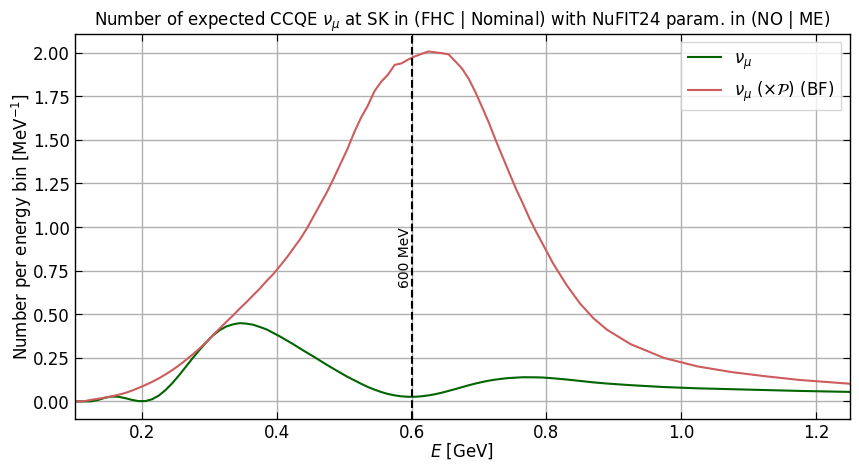

In [119]:
for key in ["numu"]:
    plt.plot(
        (sk_hist_bf.minE + sk_hist_bf.maxE) / 2,
        sk_hist_bf[key],
        label=conv.print_dict[key],
        color=colors[key],
        # alpha=.5,
        # linestyle='--',
    )

    plt.plot(
        (sk_hist_fit.minE + sk_hist_fit.maxE) / 2,
        sk_hist_fit[key],
        label=conv.print_dict[key] + r" ($\times \mathcal{P}$) (BF)",
        color="indianred",
    )


plt.axvline(x=0.6, linestyle="--", color="black")
ax = plt.gca()
plt.text(
    x=0.6,
    y=0.5,
    s=r"600 MeV",
    ha="right",
    va="top",
    rotation=90,
    transform=ax.get_xaxis_transform(),
)

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$E$ [GeV]")
plt.ylabel(r"Number per energy bin [$\text{MeV}^{-1}$]")
# plt.ylim(bottom=1e-1)
plt.xlim([0.1, 1.25])
plt.title(
    r"Number of expected CCQE $\nu_\mu$ at SK in (FHC | Nominal) with NuFIT24 param. in (NO | ME)"
)
plt.legend()

plt.show()